In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../../')
sys.path.append('../')
from utils import get_testdata_path, get_tmp_path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import time
import numpy as np
from skimage.transform import warp
from matplotlib import pyplot as plt
from pyproj import CRS
import rasterio as rio
from pyspatialkit.storage.geostorage import GeoStorage
from pyspatialkit.dataobjects.georaster import GeoRaster
from pyspatialkit.spacedescriptors.georect import GeoRect
from pyspatialkit.storage.raster.georasterlayer import GeoRasterLayer
from pyspatialkit.crs.geocrs import NoneCRS, GeoCrs


In [4]:
storage = GeoStorage(directory_path=get_tmp_path() / 'geostorage')

In [5]:
raster1 = GeoRaster.from_file(get_testdata_path() / "dop100rgbi_32_734_5748_2_st_2020.tif", band=[1,2,3])
raster2 = GeoRaster.from_file(get_testdata_path() / "dop100rgbi_32_736_5748_2_st_2020.tif", band=[1,2,3])

In [6]:
web_crs = GeoCrs(CRS.from_epsg(3857))
raster1.to_crs(web_crs)
raster2.to_crs(web_crs)

In [7]:
raster1_bounds_rect = GeoRect.from_bounds(raster1.georect.get_bounds(), crs=raster1.crs)
raster2_bounds_rect = GeoRect.from_bounds(raster2.georect.get_bounds(), crs=raster1.crs)
all_bounds = [*raster1_bounds_rect.get_bounds()[:2], *raster2_bounds_rect.get_bounds()[2:]]
print(all_bounds)
all_bounds_rect = GeoRect.from_bounds(all_bounds, crs=raster1.crs)

[1379969.3063565223, 6769962.910634506, 1386573.0052745615, 6773197.128560371]


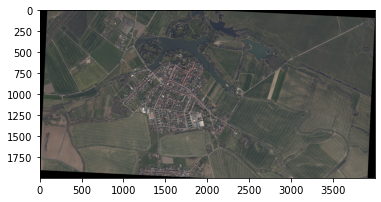

In [8]:
bounds_rect = GeoRect.from_bounds(raster1.georect.get_bounds(), crs=raster1.crs)
bounds_raster = GeoRaster(all_bounds_rect, np.zeros((2000,4000,3), dtype=np.uint8))
bounds_raster.merge_projected_other(raster1)
bounds_raster.merge_projected_other(raster2)
bounds_raster.plot()

In [9]:
mat = (np.linalg.inv(bounds_raster.transform) @ raster1.transform) 
#print(mat)
t = mat @ np.array([0,0,1])
t = t / t[2]
print(t)
img = warp(raster1.data, np.linalg.inv(mat)@np.array([[0,1,0],[1,0,0],[0,0,1]]), output_shape=(2000,2000))

[-93.803203    91.21125014   1.        ]


In [21]:
raster_layer = storage.add_raster_layer('raster_layer', 3, raster1.dtype, crs=raster1.crs, bounds=[-20026377, -20026377, 20048967, 20048967])
#raster_layer = storage.get_layer('raster_layer')

A layer with name raster_layer already exists, returning existing layer.


In [11]:
raster_layer.writer_raster_data(raster1)
raster_layer.writer_raster_data(raster2)

got bounds:[1379969 6769962 1383346 6773348]
to Indexes:[13275619 21406346 13279005 21409723]
db request took: 0.14316678047180176
backend request took: 0.14380717277526855
aligned
(3386, 3377)
got bounds:[1379969 6769962 1383346 6773348]
to Indexes:[13275619 21406346 13279005 21409723]
[13275618 21406346 13279006 21409724]
(3388, 3378, 3)
[ 6637808 10703172  6639504 10704862]
(1696, 1690, 3)
[3318904 5351586 3319752 5352432]
(848, 846, 3)
[1659452 2675792 1659876 2676216]
(424, 424, 3)
[ 829726 1337896  829938 1338108]
(212, 212, 3)
[414862 668948 414970 669054]
(108, 106, 3)
[207430 334474 207486 334528]
(56, 54, 3)
[103714 167236 103744 167264]
(30, 28, 3)
[51856 83618 51872 83632]
(16, 14, 3)
[25928 41808 25936 41816]
(8, 8, 3)
[12964 20904 12968 20908]
(4, 4, 3)
[ 6482 10452  6484 10454]
(2, 2, 3)
[3240 5226 3242 5228]
(2, 2, 3)
[1620 2612 1622 2614]
(2, 2, 3)
[ 810 1306  812 1308]
(2, 2, 3)
[404 652 406 654]
(2, 2, 3)
[202 326 204 328]
(2, 2, 3)
[100 162 102 164]
(2, 2, 3)
[50 80

In [12]:
query_rect = GeoRect((12.43652343750001, 51.8115234375), (12.48046874999999, 51.85546875), crs=GeoCrs(CRS.from_epsg(4326)))
query_rect.to_crs(raster1.crs)

In [18]:
q_rect = GeoRect([1378331.80927334, 6769590.83854613], [1384615.260079, 6773612.76104546], [1384615.260079,6769590.83854613],
[1378331.80927334, 6773612.76104546], crs=GeoCrs(CRS.from_epsg(3857)))

got bounds:[1378331 6769590 1384615 6773612]
to Indexes:[13275355 21404708 13279377 21410992]
db request took: 0.13792109489440918
backend request took: 0.13985252380371094
aligned
(1006, 1571)
reshape aligned
resize took: 0.012058496475219727


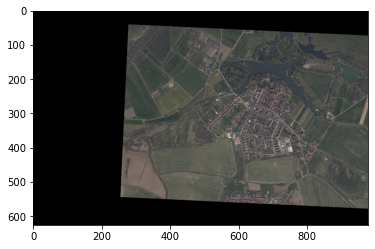

In [43]:
import pyproj
bbx = [1378331.8092733382, 6769590.838546133, 1384615.2600790022, 6773612.761045463]
CRS = 'EPSG:3857'
layer = 'raster_layer'
HEIGHT = 626
WIDTH = 978
georect = GeoRect.from_bounds(bbx, crs=GeoCrs(pyproj.CRS.from_epsg(3857)))
layer = storage.get_layer(layer)
#get_raster_start = time.time()
#try:
raster = layer.get_raster_for_rect(georect, no_data_value=int(0), resolution_rc=(int(HEIGHT), int(WIDTH)))
#raster = layer.get_raster_for_rect(q_rect, no_data_value=int(0), resolution_rc=(4000,2000))
raster.plot()

In [35]:
res = layer.get_raster_for_rect(q_rect, no_data_value=int(0), resolution_rc=(4000,2000))

got bounds:[1378331 6769590 1384615 6773612]
to Indexes:[13275355 21404708 13279377 21410992]
db request took: 0.36006999015808105
backend request took: 0.36561012268066406
aligned
(4022, 6284)
reshape aligned
resize took: 0.07541227340698242


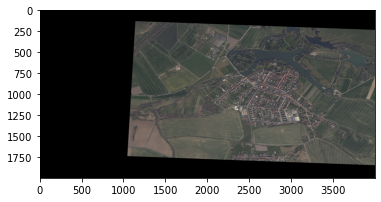

In [36]:
plt.imshow(res.data)